In [1]:
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np
import scipy.stats as stats
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess
import pybedtools as pb
import pybedtools.helpers as pbh
import pybedtools.featurefuncs as ff
import tempfile

import filenames
from dnam_preprocessing import get_targeted_dnam, compute_obs_attributes

sc_annotation_ad = pd.read_csv(filenames.SC_RNA_SEQ_ANNOTATION_CSV)
sc_ad = ad.read_h5ad(filenames.SC_RNA_SEQ_H5AD)  # 501358 cells × 3000 genes  or  501358 cells × 30877 genes
sc_df = sc_ad.to_df()  # 2.2s

sc_ad_raw = ad.AnnData(X=sc_ad.raw.X, dtype=sc_ad.X.dtype) 
sc_ad_raw.obs_names = sc_ad.raw.obs_names
sc_ad_raw.var_names = sc_ad.raw.var_names
sc_ad_raw.obs = sc_ad.obs
print(sc_ad)
print(sc_ad_raw)
# ~1m 15s to run

AnnData object with n_obs × n_vars = 501358 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tissue', 'batch', 'date', 'leiden', 'anno', 'anno2', 'annouse'
    uns: 'anno2_colors', 'anno_colors', 'batch_colors', "dendrogram_['anno']", "dendrogram_['annouse']", 'dendrogram_anno', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tissue_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 501358 × 30877
    obs: 'nCount_RNA', 'nFeature_RNA', 'tissue', 'batch', 'date', 'leiden', 'anno', 'anno2', 'annouse'


In [2]:
# Gene symbol conversion
tropid_to_laevid_df = pd.read_csv(filenames.TROP_TO_LAEV_TSV, sep='\t', header=None)
tropid_to_laevid_df[0] = tropid_to_laevid_df[0].str.split("|").apply(lambda x: x[1])
tropid_to_laevid_df[1] = tropid_to_laevid_df[1].str.split("|").apply(lambda x: x[1])
tropid_to_laevid_df = tropid_to_laevid_df[tropid_to_laevid_df[4] < 10**(-50)]  # filter by evalue
# display(tropid_to_laevid_df)

tropid_to_laevid = defaultdict(set)
for i, row in tropid_to_laevid_df.iterrows():
    laev_id = str(row[0]) 
    trop_id = str(row[1])
    tropid_to_laevid[trop_id].add(laev_id)

print(len(tropid_to_laevid), 'total trop ids with corresponding laev ids ')
print("e.g tropid_to_laevid multiset entry",next(iter(tropid_to_laevid.items())))
print()

laevid_to_laevgene_fname = filenames.LAEV_ID_TO_GENE_TXT
laevid_to_laevgene_df = pd.read_csv(laevid_to_laevgene_fname, sep='\t', header=0, names=['id', 'nothing', 'gene'])
del laevid_to_laevgene_df['nothing']
laevid_to_laevgene_df['id'] = laevid_to_laevgene_df['id'].apply(lambda x: x + '.g')
laevid_to_laevgene_df['gene'] = laevid_to_laevgene_df['gene'].apply(lambda x: x[:-2])
laevid_to_laevgene_df.set_index('id', inplace=True)

# display(laevid_to_laevgene_df)
print(len(laevid_to_laevgene_df), 'laevid_to_laevgene_df len ')
print()

atlas_gene_symbols = set(sc_ad.var_names)
atlas_raw_gene_symbols = set(sc_ad.raw.var.features)
print("some atlas gene symbols", list(atlas_gene_symbols)[3:15])
print("len(atlas_gene_symbols)", len(atlas_gene_symbols))
print("len(atlas_raw_gene_symbols)", len(atlas_raw_gene_symbols))
print()

a = set(tropid_to_laevid_df[0]) # laev ids in the mapping from trop id to laev id
b = set(laevid_to_laevgene_df.index) # laev ids in the mapping from laev id to laev gene
print(f"{len(a)} total laev ids  ->  {len(a.intersection(b))} laev ids that have a corresponding gene symb")
print()

tropid_to_laevatlascols = defaultdict(set)
for trop_id, laev_ids in tropid_to_laevid.items():
    for laev_id in laev_ids:
        if laev_id in laevid_to_laevgene_df.index:
            laev_gene = laevid_to_laevgene_df.loc[laev_id]['gene']
            if laev_gene + '.L' in atlas_raw_gene_symbols:
                tropid_to_laevatlascols[trop_id].add(laev_gene + '.L')
            if laev_gene + '.S' in atlas_raw_gene_symbols:
                tropid_to_laevatlascols[trop_id].add(laev_gene + '.S')
        if laev_id in atlas_gene_symbols:
            tropid_to_laevatlascols[trop_id].add(laev_id)
            
print(f"{len(tropid_to_laevatlascols)} total trop ids with laev atlas cols")

18491 total trop ids with corresponding laev ids 
e.g tropid_to_laevid multiset entry ('XBXT10g018392', {'Xelaev18038061m.g', 'Xelaev18036213m.g', 'Xelaev18003427m.g', 'Xelaev18004535m.g', 'Xelaev18003428m.g', 'Xelaev18000001m.g', 'Xelaev18036214m.g', 'Xelaev18036520m.g', 'Xelaev18036521m.g'})

22254 laevid_to_laevgene_df len 

some atlas gene symbols ['pfkfb4.S', 'dcn.L', 'slc5a7-like.2.L', 'cryaa.S', 'neurl3.L', 'Xelaev18003427m.g', 'Xelaev18003790m.g', 'gpm6a.L', 'l1cam.S', 'col4a6-like.L', 'erp27.L', 'kcnj13.S']
len(atlas_gene_symbols) 3000
len(atlas_raw_gene_symbols) 30877

33288 total laev ids  ->  22018 laev ids that have a corresponding gene symb

12831 total trop ids with laev atlas cols


In [3]:
# Get tropicalis gene IDs nearby to with age-associated CpG sites of interest
ad10_all, ad100_all, ad10, ad100, df_testset, ages_testset = get_targeted_dnam()

ad100_notadpoles = ad100.copy()
ad100_notadpoles = ad100_notadpoles[:, ~ad100_notadpoles.var['Is tadpole?']]
compute_obs_attributes(ad100_notadpoles)

ad10_notadpoles = ad10.copy()
ad10_notadpoles = ad10_notadpoles[:, ~ad10_notadpoles.var['Is tadpole?']]
compute_obs_attributes(ad10_notadpoles)

p_adj = stats.false_discovery_control(ad100_notadpoles.obs['spearman_p'], method='bh')
ad100_notadpoles.obs['p_adj'] = p_adj

def coord_with_colon_to_bedline(x):
    chr = x.split('Chr')[1].split(':')[0]   
    start = int(x.split(':')[1])
    stop = start + 1
    return f"Chr{chr}\t{start}\t{stop}"

def get_bedtool_obj(it):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".bed") as temp_input_file:
        for bedline, corr in it:
            temp_input_file.write((coord_with_colon_to_bedline(bedline) + "\t" + str(corr) + "\n").encode())
        temp_input_filename = temp_input_file.name
    with tempfile.NamedTemporaryFile(delete=False, suffix=".bed") as temp_output_file:
        temp_output_filename = temp_output_file.name
    subprocess.run(f'cat {temp_input_filename} | sort -k1,1 -k2,2n > {temp_output_filename}', shell=True)
    return pb.BedTool(temp_output_filename)

FDR_LEVEL = 0.001
pos_cpgs = get_bedtool_obj(ad100_notadpoles[(ad100_notadpoles.obs['p_adj'] < FDR_LEVEL) & (ad100_notadpoles.obs['spearman'] > 0)].obs['spearman'].items())
neg_cpgs = get_bedtool_obj(ad100_notadpoles[(ad100_notadpoles.obs['p_adj'] < FDR_LEVEL) & (ad100_notadpoles.obs['spearman'] < 0)].obs['spearman'].items())
all_tbs_cpgs = get_bedtool_obj(ad10_notadpoles.obs['spearman'].items())

print(len(pos_cpgs), len(neg_cpgs), len(all_tbs_cpgs))

def cpg_to_tss(cpgs, TSSes):
    nearby = cpgs.closest(TSSes, D=['b'])  # print("command ran: ", " ".join(nearby._cmds))
    tss_to_closest_cpg = {}  # key: gene_id  value: list of (cpg_loc, dist)
    ids = set()
    for bedtools_closest_line in nearby:
        # parse
        l = bedtools_closest_line.fields  # list indicating basically 2 bed lines combined together
        ll = bedtools_closest_line.fields[-2].split(';')  # list of info about gene
        cpg_loc = l[0] + ':' +  l[1]
        corr = float(l[3])
        dist = int(l[-1])
        gene_id = ll[0][3:]
        ids.add(cpg_loc)
        # tss_loc = l[-10] + ':' +  l[-7]
        # gene_name = ll[-3][5:]
        # gene_biotype = ll[-2]
        k = gene_id
        if k not in tss_to_closest_cpg or abs(dist) < abs(tss_to_closest_cpg[k][1]): 
            tss_to_closest_cpg[k] = (cpg_loc, dist)

    print(f"{len(cpgs)} cpgs -> {len(tss_to_closest_cpg.keys())} TSSes")
    return tss_to_closest_cpg


TSSes = pb.BedTool(filenames.XENTRO_V10_GFF3)  # can think of as iterable of Interval objects, LAZILY on disk.
is_chr = lambda x: x.chrom[:3] == "Chr"   
is_gene = lambda x: x['gbkey'] == 'Gene' 
is_protein_coding = lambda x: x['gbkey'] == 'Gene' and x['gene_biotype'] == 'protein_coding' 
extract_TSS = lambda x: ff.TSS(x, upstream=0, downstream=2)

TSSes = filter(is_chr, TSSes)  # NOTE there are 83 protein coding ScaN and MT in the dataset... XBXT10g023778 XBXT10g023778 XBXT10g017061 XBXT10g017061
TSSes = filter(is_gene, TSSes)
# TSSes = filter(is_protein_coding, TSSes)
TSSes = map(extract_TSS, TSSes)  # remove this if you want the full genes
TSSes = pb.BedTool(TSSes).sort().saveas(pbh.get_tempdir() + "TSSes.bed")

top_genes = []
bottom_genes = []

DIST_CUTOFF = 5000  
for gene_id, (cpg_loc, dist) in cpg_to_tss(pos_cpgs, TSSes).items():
    if dist <= DIST_CUTOFF:
        top_genes.append(str(gene_id))

for gene_id, (cpg_loc, dist) in cpg_to_tss(neg_cpgs, TSSes).items():
    if dist <= DIST_CUTOFF:
        bottom_genes.append(str(gene_id))

print('--> ', len(top_genes), 'TSSes within dist cutoff')
print('--> ', len(bottom_genes), 'TSSes within dist cutoff')

/Users/ronan/_xenopus-aging/xenopus-aging/TBS_paper/dnam_preprocessing.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_out.obs['Site'] = list(ad_out.obs_names)
/Users/ronan/_xenopus-aging/xenopus-aging/TBS_paper/dnam_preprocessing.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_out.obs['Site'] = list(ad_out.obs_names)


326 1907 25362
326 cpgs -> 157 TSSes
1907 cpgs -> 836 TSSes
-->  97 TSSes within dist cutoff
-->  456 TSSes within dist cutoff


In [4]:
# DNAM GENES
def compute_sites_lost(genes_to_use):
    tropids_in_atlas = [gene for gene in genes_to_use if gene in tropid_to_laevatlascols]
    laev_genes = [sorted(list(tropid_to_laevatlascols[tropid]))[0] for tropid in tropids_in_atlas] # TODO: taking the 0th element here
    tropids_with_laevids = len([g for g in genes_to_use if g in tropid_to_laevid])
    print(f" {len(set(genes_to_use))} trop ids  ->  {tropids_with_laevids} laev ids  ->  {len(set(laev_genes))} laev entries in atlas")
    return laev_genes

top_genes_laev = compute_sites_lost(top_genes)
bottom_genes_laev = compute_sites_lost(bottom_genes)

all_laev_genes = sc_ad_raw.var_names
print(len(all_laev_genes))
# top_genes_laev.remove('prl.1.L')
print(len(top_genes_laev))
print(bottom_genes_laev[:5])

 97 trop ids  ->  54 laev ids  ->  37 laev entries in atlas
 456 trop ids  ->  299 laev ids  ->  208 laev entries in atlas
30877
37
['ptcd3.L', 'gpr78.L', 'galnt7.S', 'anxa10.L', 'tdo2.L']


TOP EXP
Bladder 561604.0 0.8586207514275915 ((37,), (30877,))
Bone Marrow 565578.5 0.91564106089861 ((37,), (30877,))
Brain 576417.5 0.9236720985025666 ((37,), (30877,))
Eye 616018.0 0.408185876070128 ((37,), (30877,))
Heart 606271.0 0.5166065763662826 ((37,), (30877,))
Intestine 533252.5 0.480492755011416 ((37,), (30877,))
Kidney 555098.0 0.7650441713515672 ((37,), (30877,))
Liver 551340.0 0.711640587205124 ((37,), (30877,))
Lung 582526.5 0.8341876601470715 ((37,), (30877,))
Muscle 594063.5 0.6717775084535069 ((37,), (30877,))
Ovary 581916.0 0.8431346758243461 ((37,), (30877,))
Oviduct 603919.5 0.5433752270026582 ((37,), (30877,))
Pancreas 571080.5 0.9978798171596484 ((37,), (30877,))
Skin 592326.5 0.6884756530765566 ((37,), (30877,))
Spleen 534765.0 0.4965600321094268 ((37,), (30877,))
Stomach 555768.0 0.7747084492043375 ((37,), (30877,))
Bladder 0.9852502384027377 
Bone Marrow 0.9852502384027377 
Brain 0.9852502384027377 
Eye 0.9852502384027377 
Heart 0.9852502384027377 
Intestine 0

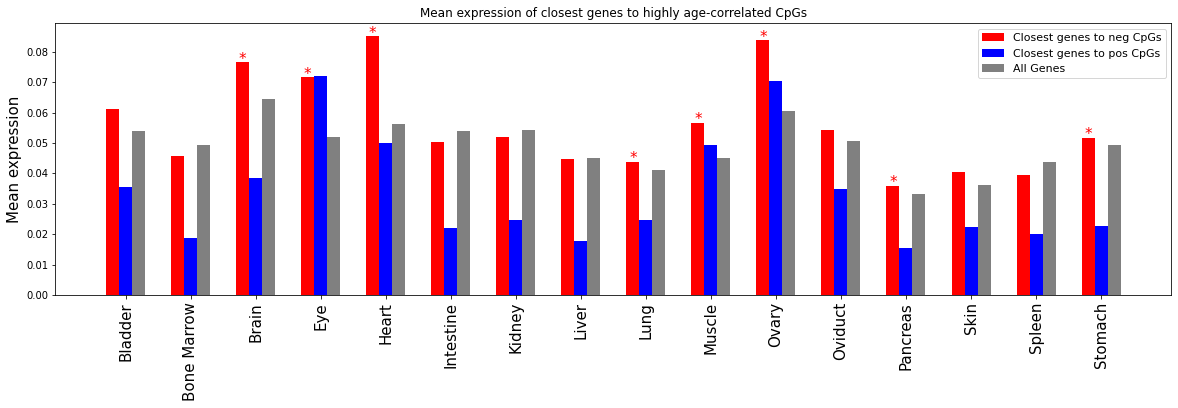

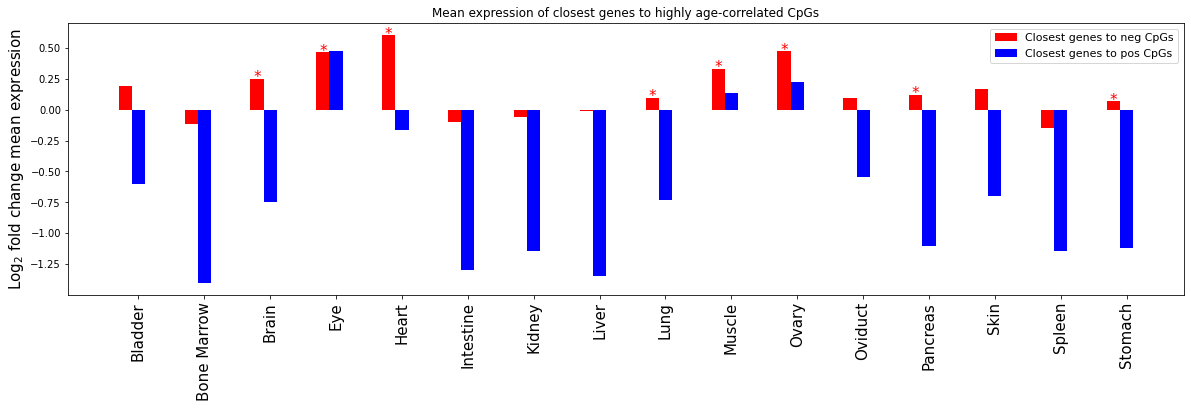

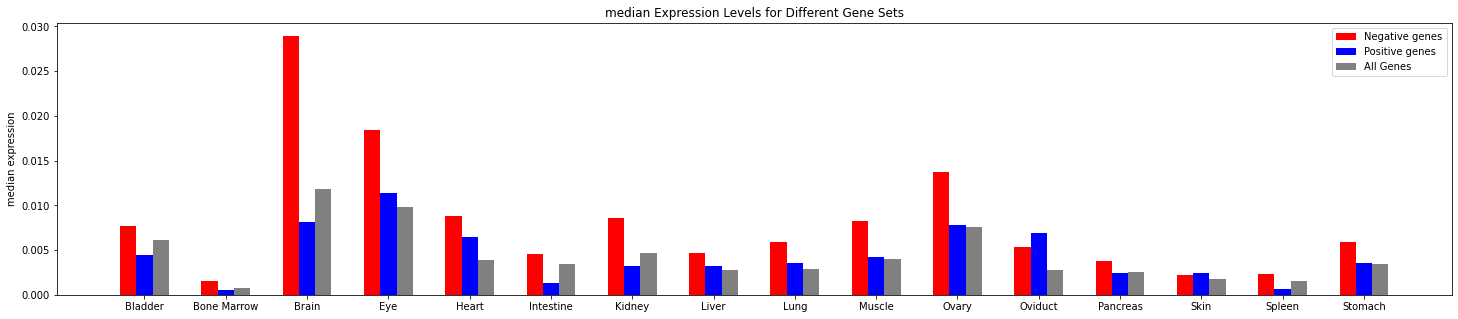

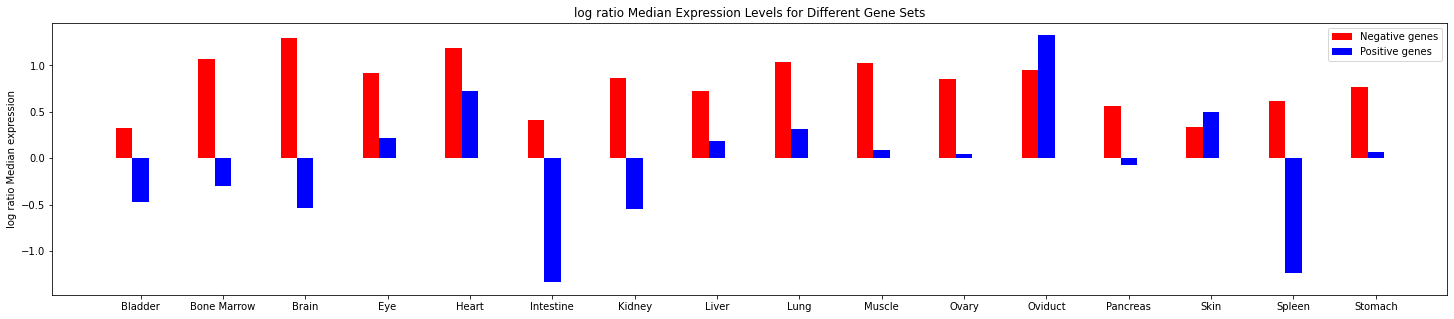

In [5]:
# single cell expression bar chart
def compute_average_expression(genes_of_interest, sc_ad_raw, tissues):
    # create matrix (anndata) to hold the data for the figure
    # rows: tissue.celltype
    # cols: age-associated genes of interest
    # entries: AVERAGE expression of that gene across all cells of that tissue.celltype
    rows = tissues
    cols = genes_of_interest
    data_matrix = np.zeros((len(rows), len(cols)))
    heatmap_ad = ad.AnnData(X=data_matrix, dtype=data_matrix.dtype)
    heatmap_ad.var_names = genes_of_interest
    heatmap_ad.obs_names = rows
    for tissue in tissues:
        # select all cells of this tissue, only expression for genes_of_interest. Compute mean expression across all such cells.
        heatmap_ad[tissue] = sc_ad_raw[sc_ad_raw.obs['tissue'] == tissue, genes_of_interest].X.mean(axis=0)
        # print(tissue, "# cells = ",sc_ad_raw[sc_ad_raw.obs['tissue'] == tissue, genes_of_interest].shape[0])
    return heatmap_ad.X

def compute_median_expression(genes_of_interest, sc_ad_raw, tissues):
    # create matrix (anndata) to hold the data for the figure
    # rows: tissue.celltype
    # cols: age-associated genes of interest
    # entries: AVERAGE expression of that gene across all cells of that tissue.celltype
    rows = tissues
    cols = genes_of_interest
    data_matrix = np.zeros((len(rows), len(cols)))
    heatmap_ad = ad.AnnData(X=data_matrix, dtype=data_matrix.dtype)
    heatmap_ad.var_names = genes_of_interest
    heatmap_ad.obs_names = rows
    for tissue in tissues:
        # select all cells of this tissue, only expression for genes_of_interest. Compute mean expression across all such cells.
        heatmap_ad[tissue] = np.median(sc_ad_raw[sc_ad_raw.obs['tissue'] == tissue, genes_of_interest].X, axis=0)
    return heatmap_ad.X


tissues = list(sc_ad_raw.obs['tissue'].unique())
tissues = tissues[:-5]  # exclude embryo stages

bottom_exp = compute_average_expression(bottom_genes_laev, sc_ad_raw, tissues)
top_exp = compute_average_expression(top_genes_laev, sc_ad_raw, tissues)
all_exp = compute_average_expression(all_laev_genes, sc_ad_raw, tissues)

print('TOP EXP')
ps = []
for x,y, tissue in zip(top_exp, all_exp, tissues):
    # t_out = stats.ttest_ind(x,y, equal_var=False)  # Welch's
    t_out = stats.mannwhitneyu(x, y, alternative='two-sided')
    ps.append(t_out.pvalue)
    print(tissue, t_out.statistic, t_out.pvalue, (x.shape,y.shape))
p_adj = stats.false_discovery_control(ps, method='bh')
for p, tissue in zip(p_adj, tissues):
    print(tissue, p, '*' if p < 0.05 else '')

topstars = ['*' if p < 0.05 else '' for p in p_adj]

print('-----')
print('BOTTOM EXP')
ps = []
for x,y, tissue in zip(bottom_exp, all_exp, tissues):
    # t_out = stats.ttest_ind(x,y, equal_var=False)  # Welch's
    t_out = stats.mannwhitneyu(x, y, alternative='two-sided')
    ps.append(t_out.pvalue)
    print(tissue, t_out.statistic, t_out.pvalue, (x.shape,y.shape))
print(ps)
p_adj = stats.false_discovery_control(ps, method='bh')
print(p_adj)
for p, tissue in zip(p_adj, tissues):
    print(tissue, p, '*' if p < 0.05 else '')
bottomstars = ['*' if p < 0.05 else '' for p in p_adj]

bottomgenes_tissue_avgs = bottom_exp.mean(axis=1)
topgenes_tissue_avgs = top_exp.mean(axis=1)
allgenes_tissue_avgs = all_exp.mean(axis=1)

bottomgenes_ratio = bottomgenes_tissue_avgs / allgenes_tissue_avgs
topgenes_ratio = topgenes_tissue_avgs / allgenes_tissue_avgs

print("Sample size: positive genes: ", len(top_genes_laev), ' negative genes: ', len(bottom_genes_laev) )

# Plotting
rotation = 90
fontsize = 15
plt.figure(figsize=(20, 5))
x_axis = np.arange(len(tissues))
bar_offset = 0.2

plt.bar(x_axis - bar_offset, bottomgenes_tissue_avgs, bar_offset, label='Closest genes to neg CpGs', color='red')
plt.bar(x_axis,              topgenes_tissue_avgs,    bar_offset, label='Closest genes to pos CpGs', color='blue')
plt.bar(x_axis + bar_offset, allgenes_tissue_avgs,    bar_offset, label='All Genes', color='gray')
plt.xticks(x_axis, tissues, rotation=rotation, fontsize=fontsize)
plt.ylabel('Mean expression', fontsize=fontsize)
plt.title('Mean expression of closest genes to highly age-correlated CpGs')
plt.legend(fontsize=fontsize//1.3)
for i in range(len(x_axis)):
    plt.text(x_axis[i],              topgenes_tissue_avgs[i] - 0.0015, topstars[i], ha='center', va='bottom', fontsize=fontsize, color='blue')
    plt.text(x_axis[i] - bar_offset, bottomgenes_tissue_avgs[i] - 0.0015, bottomstars[i], ha='center', va='bottom', fontsize=fontsize, color='red')
plt.show()

# plt.figure(figsize=(25, 5))
# plt.bar(x_axis - bar_offset, bottomgenes_ratio, bar_offset, label='Genes nearby to CpGs that decrease in methylation with age', color='red')
# plt.bar(x_axis,              topgenes_ratio,    bar_offset, label='Genes nearby to CpGs that increase in methylation with age', color='blue')
# plt.xticks(x_axis, tissues) 
# plt.ylabel('Average expression')
# plt.title('Average Expression Levels for Different Gene Sets')
# plt.axhline(y=1, linestyle='-')
# plt.legend()
# plt.show()

plt.figure(figsize=(20, 5))
plt.bar(x_axis - bar_offset, np.log2(bottomgenes_ratio), bar_offset, label='Closest genes to neg CpGs', color='red')
plt.bar(x_axis,              np.log2(topgenes_ratio),    bar_offset, label='Closest genes to pos CpGs', color='blue')
plt.xticks(x_axis, tissues, rotation=rotation, fontsize=fontsize)
plt.ylabel('Log$_{2}$ fold change mean expression', fontsize=fontsize)
plt.title('Mean expression of closest genes to highly age-correlated CpGs')
plt.legend(fontsize=fontsize//1.3)

for i in range(len(x_axis)):
    plt.text(x_axis[i],              np.log2(topgenes_ratio[i]) - 0.1, topstars[i], ha='center', va='bottom', fontsize=fontsize, color='blue')
    plt.text(x_axis[i] - bar_offset, np.log2(bottomgenes_ratio[i]) - 0.05, bottomstars[i], ha='center', va='bottom', fontsize=fontsize, color='red')

plt.show()

plt.figure(figsize=(25, 5))
plt.bar(x_axis - bar_offset, np.median(bottom_exp, axis=1), bar_offset, label='Negative genes', color='red')
plt.bar(x_axis,              np.median(top_exp, axis=1),    bar_offset, label='Positive genes', color='blue')
plt.bar(x_axis + bar_offset, np.median(all_exp, axis=1),    bar_offset, label='All Genes', color='gray')
plt.xticks(x_axis, tissues) 
plt.ylabel('median expression')
plt.title('median Expression Levels for Different Gene Sets')
plt.legend()
plt.show()


plt.figure(figsize=(25, 5))
plt.bar(x_axis - bar_offset, np.log2(np.median(bottom_exp, axis=1) / np.median(all_exp, axis=1)) , bar_offset, label='Negative genes', color='red')
plt.bar(x_axis,              np.log2(np.median(top_exp, axis=1) / np.median(all_exp, axis=1)),    bar_offset, label='Positive genes', color='blue')
plt.xticks(x_axis, tissues) 
plt.ylabel('log ratio Median expression')
plt.title('log ratio Median Expression Levels for Different Gene Sets')
plt.legend()
plt.show()